 # Temporal Fusion Transformer(TFT)

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings


In [ ]:
# loading datas

In [5]:
data = pd.read_csv('df_clean.csv')

In [6]:
series = TimeSeries.from_dataframe(data, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

In [7]:
data.shape


(26304, 3)

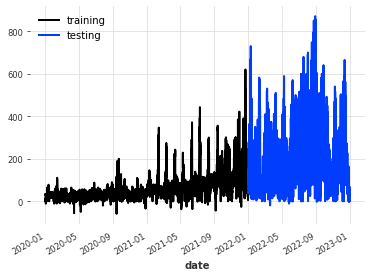

In [8]:
# dart recommendation, splitting dataset into train ad test
# 2 yrs train and 1 year test
# no random split as the data is timeseries data
train, test = series.split_before(pd.Timestamp("01.01.2022 01:00"))
#train, test = series[:-100], series[-100:]
train.plot(label="training")
test.plot(label="testing")

In [9]:
# Normalize the time series (note: we avoid fitting the transformer on the test set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)
transformer.fit(train_transformed)



Scaler

In [10]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)


In [11]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(pd.Timestamp('2022-01-01 01:00:00'))
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)


# Create a Model

In [12]:
input_chunk_length =168 
forecast_horizon = 48

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]


my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=1,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [14]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResid

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7f647666d820>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=48, batch_size=16, n_epochs=1, add_encoders=None, random_state=42)

In [15]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

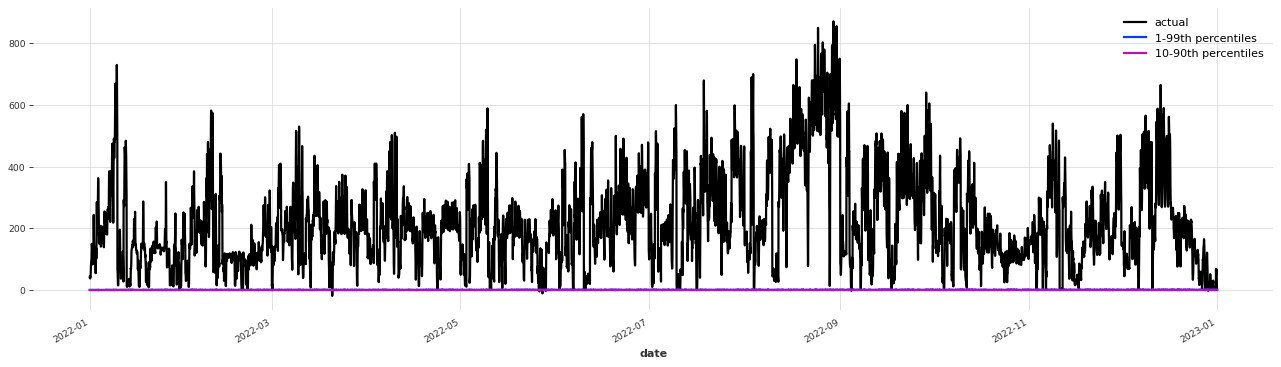

In [16]:
pred = my_model.predict(n=len(test), num_samples=1)

lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(low_quantile=lowest_q, 
          high_quantile=highest_q, 
          label=label_q_outer
          )
pred.plot(low_quantile=low_q,
          high_quantile=high_q, 
          label=label_q_inner
          )
plt.show()

In [21]:
pred = my_model.historical_forecasts(series,
                                    forecast_horizon=24, 
                                    future_covariates=covariates_transformed,
                                    stride=24, 
                                    #train_length=336, 
                                    retrain=False,
                                    start=pd.Timestamp("01.01.2022 01:00"), 
                                    verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

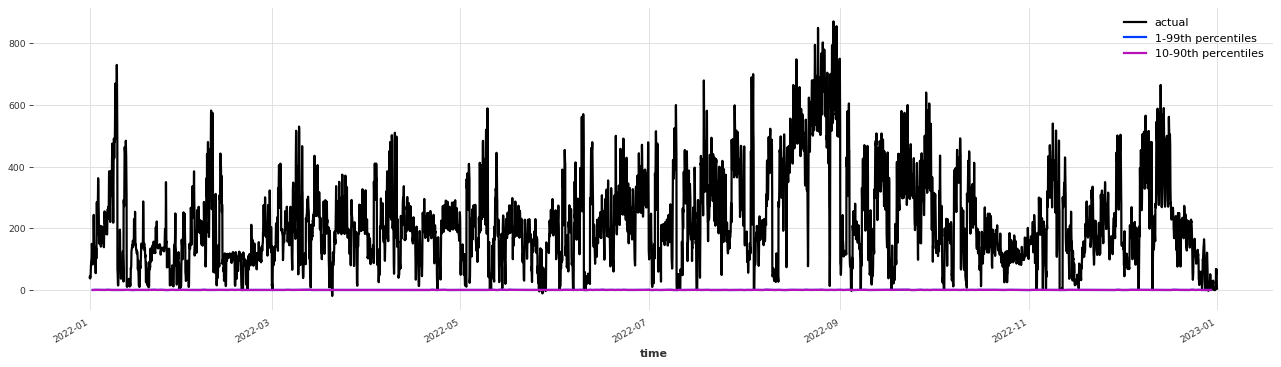

In [22]:
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(low_quantile=lowest_q, 
          high_quantile=highest_q, 
          label=label_q_outer
          )
pred.plot(low_quantile=low_q,
          high_quantile=high_q, 
          label=label_q_inner
          )
plt.show()